In [1]:
import torch
import time
import numpy as np


In [2]:
torch.set_grad_enabled(False);

In [3]:
HOME_DIR = ".."
dtype = torch.bfloat16
DEVICE_NAME = "a100"

In [6]:
# Define matrix size
def setup_matmul_benchmark(batch_size=16, M=2048, N=4096, K=4096, use_batch=False, device='cuda', dtype=torch.bfloat16):
    """
    Set up matrices for matrix multiplication benchmark and calculate theoretical FLOPs.
    
    Args:
        batch_size: Number of matrices in the batch
        M: First dimension (seg_len)
        N: Output dimension (out_dim)
        K: Hidden dimension (hid_dim)
        use_batch: Whether to use batched weights
        device: Device to create tensors on
        dtype: Data type for tensors
        
    Returns:
        a: Input tensor
        b: Weight tensor
        flops: Theoretical FLOPs for the operation
    """
    a = torch.rand((batch_size, M, K), device=device, dtype=dtype)
    b_single = torch.rand((K, N), device=device, dtype=dtype)
    b_batch = torch.rand((batch_size, K, N), device=device, dtype=dtype)
    
    b = b_single if not use_batch else b_batch
    
    # Calculate FLOPS
    flops = batch_size * M * N * (2 * K)
    
    return a, b, flops

# Define matrix size
batch_size = 16
M = 4096  # seg_len
N = 2048  # out_dim
K = 2048  # hid_dim
use_batch = False

a, b, flops = setup_matmul_benchmark(batch_size, M, N, K, use_batch, device='cuda', dtype=dtype)

In [7]:
def measure_execution_time_matmul(operation, a, b, flops, num_runs=75):
    """
    Measure the performance of a given operation in FLOPS.
    
    Args:
        operation: Function to benchmark (e.g., torch.matmul)
        a: First input tensor
        b: Second input tensor
        flops: Theoretical FLOPs for the operation
        num_runs: Number of runs to average over
        
    Returns:
        achieved_flops: Achieved FLOPS for the operation
    """
    # Warm-up
    for _ in range(15):
        operation(a, b)
    
    # Measure execution time
    elapsed_times = []
    
    for _ in range(num_runs):
        start = time.time()
        operation(a, b)
        torch.cuda.synchronize()
        end = time.time()
        elapsed_times.append(end - start)
    
    # start = time.time()
    # for _ in range(num_runs):
    #     # start = time.time()
    #     a = operation(a, b)
    # torch.cuda.synchronize()
    # end = time.time()
    # elapsed_times.append(end - start)
    
    # Use the average time for better estimation
    elapsed_time = sum(elapsed_times) / num_runs
    
    return elapsed_time


In [8]:
torch.cuda.empty_cache()

In [9]:

# Measure performance of torch.matmul
elapsed_time = measure_execution_time_matmul(torch.matmul, a, b, flops)
# Calculate FLOPS
achieved_flops = flops / elapsed_time
print(f"Achieved FLOPS: {achieved_flops:.2e}")

Achieved FLOPS: 2.05e+14


In [10]:
import cutlass

USE_EFFICIENT_ALLOCATION = True
def group_gemm_jit(As, Bs, use_efficient_allocation=False, Bs_transposed=False):
    dtype = As[0].dtype
    # print(f"GROUPED GEMM dtype: {dtype}")
    plan = cutlass.op.GroupedGemm(
        element=dtype, 
        element_accumulator=torch.float32, 
        layout_A = cutlass.LayoutType.RowMajor,
        layout_B = cutlass.LayoutType.RowMajor if not Bs_transposed else cutlass.LayoutType.ColumnMajor,
        layout_C = cutlass.LayoutType.RowMajor,
        )

    Cs = [torch.zeros(a.shape[:-1] + (b.shape[-1],), dtype=a.dtype, device=a.device) for a,b in zip(As, Bs)]
    Ds = [torch.zeros_like(el) for el in Cs]
    
    plan.run(As, Bs, Cs, Ds, print_module=True)
    op = plan.construct()

    if use_efficient_allocation or USE_EFFICIENT_ALLOCATION:
        print("USE_EFFICIENT_ALLOCATION")
        import grouped_batching.cutlass_emit_pytorch_mocked as cutlass_emit_pytorch_mocked
        grouped_gemm = cutlass_emit_pytorch_mocked.pytorch(op, name='grouped_gemm', cc=plan.cc, sourcedir='out', jit=True)
    else:
        grouped_gemm = cutlass.emit.pytorch(op, name='grouped_gemm', cc=plan.cc, sourcedir='out', jit=True)

    return grouped_gemm

In [11]:
group_gemm_fn = group_gemm_jit(a.unbind(0), b.unbind(0) if use_batch else [b]*batch_size)


// Gemm operator cutlass_tensorop_bf16_s16816gemm_grouped_bf16_256x128_64x3_tt_align8
using cutlass_tensorop_bf16_s16816gemm_grouped_bf16_256x128_64x3_tt_align8_base =
  typename cutlass::gemm::kernel::DefaultGemmGrouped<
    cutlass::bfloat16_t, cutlass::layout::RowMajor, cutlass::ComplexTransform::kNone, 8,
    cutlass::bfloat16_t, cutlass::layout::RowMajor, cutlass::ComplexTransform::kNone, 8,
    cutlass::bfloat16_t, cutlass::layout::RowMajor,
    float,
    cutlass::arch::OpClassTensorOp,
    cutlass::arch::Sm80,
    cutlass::gemm::GemmShape<256, 128, 64>,
    cutlass::gemm::GemmShape<64, 64, 64>,
    cutlass::gemm::GemmShape<16, 8, 16>,
    cutlass::epilogue::thread::LinearCombination<cutlass::bfloat16_t, 8, float, float>,
    cutlass::gemm::threadblock::GemmIdentityThreadblockSwizzle<1>,
    3,
    cutlass::gemm::kernel::GroupScheduleMode::kDeviceOnly,
    cutlass::arch::OpMultiplyAdd
>::GemmKernel;

// Define named type
struct cutlass_tensorop_bf16_s16816gemm_grouped_bf16_256x

In [12]:
def measure_execution_time_grouped_gemm(fn, a, b_to_use, num_runs=75):
    """
    Measure the execution time of a function over multiple runs.
    
    Args:
        fn: The function to measure
        a: Input tensor A
        b_to_use: Input tensor B (or list of tensors)
        num_runs: Number of runs to average over
        
    Returns:
        Average execution time in seconds
    """
    for _ in range(15):
        fn.run(a.unbind(0), b_to_use)
    torch.cuda.synchronize()
    
    elapsed_times = []
    
    # for _ in range(num_runs):
    #     start = time.time()
    #     fn.run(a.unbind(0), b_to_use)
    #     torch.cuda.synchronize()
        
    #     end = time.time()
    #     elapsed_times.append(end - start)
    
    start = time.time()
    for _ in range(num_runs):
        a = fn.run(a.unbind(0), b_to_use)
        torch.cuda.synchronize()
        
    end = time.time()
    elapsed_times.append(end - start)
    
    # Use the average time for better estimation
    return sum(elapsed_times) / num_runs

In [13]:


# Prepare inputs
b_to_use = b.unbind(0) if use_batch else [b]*batch_size

# Measure execution time
elapsed_time = measure_execution_time_grouped_gemm(group_gemm_fn, a, b_to_use)

# Calculate achieved FLOPS
achieved_flops = flops / elapsed_time
print(f"Achieved FLOPS: {achieved_flops:.2e}")

Achieved FLOPS: 2.25e+14


In [14]:
torch.cuda.empty_cache()

In [15]:
# Define parameter ranges to test
batch_sizes = list(range(1, 17)) # + [32, 48, 64] #[8, 16, 32]
seq_lengths = [4096]
hidden_sizes = [2048]

# batch_sizes = [16]
# seq_lengths = [1024*2]
# hidden_sizes = [1024*4]

# Lists to store results
results = []

# Iterate over all parameter combinations
for batch_size in batch_sizes:
    for seq_len in seq_lengths:
        for hidden_size in hidden_sizes:
            print(f"Testing batch_size={batch_size}, seq_len={seq_len}, hidden_size={hidden_size}")
            
            # Create input tensors
            a = torch.randn(batch_size, seq_len, hidden_size, device='cuda', dtype=dtype)
            b = torch.randn(batch_size, hidden_size, hidden_size, device='cuda', dtype=dtype)
            
            # Calculate theoretical FLOPs
            flops = 2 * batch_size * seq_len * hidden_size * hidden_size

            use_b_manual = b # [0:1] # really we compute this at ones with batching
            
            matmul_time = measure_execution_time_matmul(torch.matmul, a, b, flops)
            matmul_flops = flops / matmul_time
            
            # Test grouped gemm
            # group_gemm_fn = GroupedGEMM()
            b_to_use = b.unbind(0) if use_batch else [b]*batch_size
            
            grouped_gemm_time = measure_execution_time_grouped_gemm(group_gemm_fn, a, b_to_use)
            grouped_gemm_flops = flops / grouped_gemm_time
            
            # Store results
            results.append({
                'batch_size': batch_size,
                'seq_len': seq_len,
                'hidden_size': hidden_size,
                'matmul_time': matmul_time,
                'matmul_flops': matmul_flops,
                'grouped_gemm_time': grouped_gemm_time,
                'grouped_gemm_flops': grouped_gemm_flops,
                'speedup': matmul_time / grouped_gemm_time
            })
            
            # Print current result
            print(f"  MatMul: {matmul_flops:.2e} FLOPS, GroupedGEMM: {grouped_gemm_flops:.2e} FLOPS")
            print(f"  Speedup: {matmul_time / grouped_gemm_time:.2f}x")

Testing batch_size=1, seq_len=4096, hidden_size=2048
  MatMul: 1.49e+14 FLOPS, GroupedGEMM: 1.40e+14 FLOPS
  Speedup: 0.94x
Testing batch_size=2, seq_len=4096, hidden_size=2048
  MatMul: 1.88e+14 FLOPS, GroupedGEMM: 1.84e+14 FLOPS
  Speedup: 0.98x
Testing batch_size=3, seq_len=4096, hidden_size=2048
  MatMul: 1.93e+14 FLOPS, GroupedGEMM: 1.82e+14 FLOPS
  Speedup: 0.94x
Testing batch_size=4, seq_len=4096, hidden_size=2048
  MatMul: 2.03e+14 FLOPS, GroupedGEMM: 1.99e+14 FLOPS
  Speedup: 0.98x
Testing batch_size=5, seq_len=4096, hidden_size=2048
  MatMul: 2.05e+14 FLOPS, GroupedGEMM: 2.09e+14 FLOPS
  Speedup: 1.02x
Testing batch_size=6, seq_len=4096, hidden_size=2048
  MatMul: 2.04e+14 FLOPS, GroupedGEMM: 2.06e+14 FLOPS
  Speedup: 1.01x
Testing batch_size=7, seq_len=4096, hidden_size=2048
  MatMul: 2.03e+14 FLOPS, GroupedGEMM: 2.13e+14 FLOPS
  Speedup: 1.05x
Testing batch_size=8, seq_len=4096, hidden_size=2048
  MatMul: 2.09e+14 FLOPS, GroupedGEMM: 2.20e+14 FLOPS
  Speedup: 1.05x
Testing 

In [16]:
# Convert results to DataFrame for easier analysis
import pandas as pd
results_df = pd.DataFrame(results)
display(results_df)



,batch_size,seq_len,hidden_size,matmul_time,matmul_flops,grouped_gemm_time,grouped_gemm_flops,speedup
0,1,4096,2048,0.000230,1.491793e+14,0.000246,1.397115e+14,0.936534
1,2,4096,2048,0.000365,1.881285e+14,0.000373,1.844084e+14,0.980226
2,3,4096,2048,0.000533,1.934386e+14,0.000568,1.816171e+14,0.938888
3,4,4096,2048,0.000677,2.031002e+14,0.000690,1.993056e+14,0.981316
4,5,4096,2048,0.000836,2.054070e+14,0.000822,2.089231e+14,1.017118
5,6,4096,2048,0.001008,2.044464e+14,0.001001,2.058599e+14,1.006914
6,7,4096,2048,0.001182,2.034737e+14,0.001129,2.129925e+14,1.046781
7,8,4096,2048,0.001314,2.092336e+14,0.001250,2.198570e+14,1.050773
8,9,4096,2048,0.001480,2.089025e+14,0.001446,2.138762e+14,1.023809
9,10,4096,2048,0.001655,2.076727e+14,0.001570,2.188458e+14,1.053801


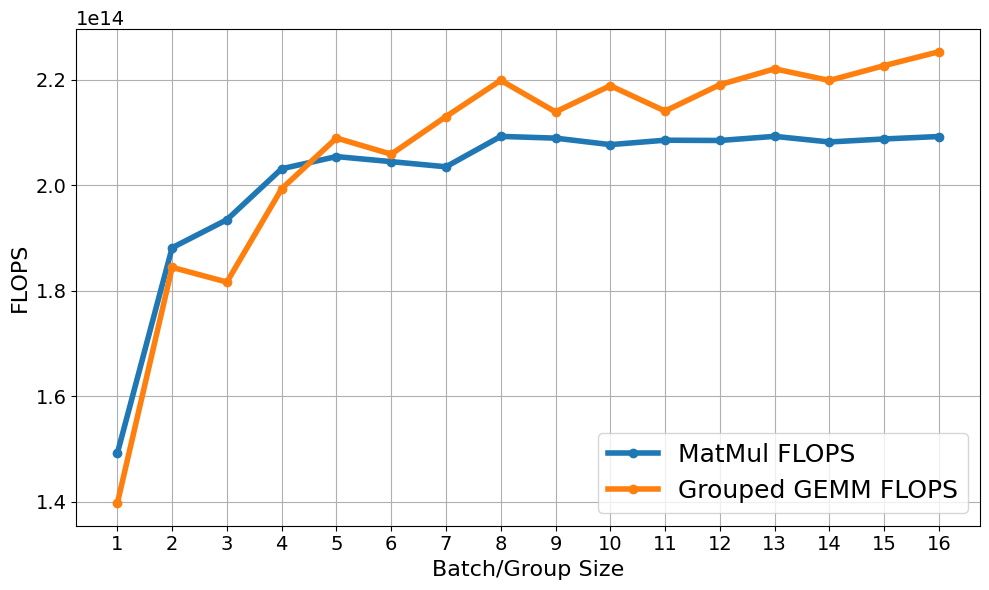

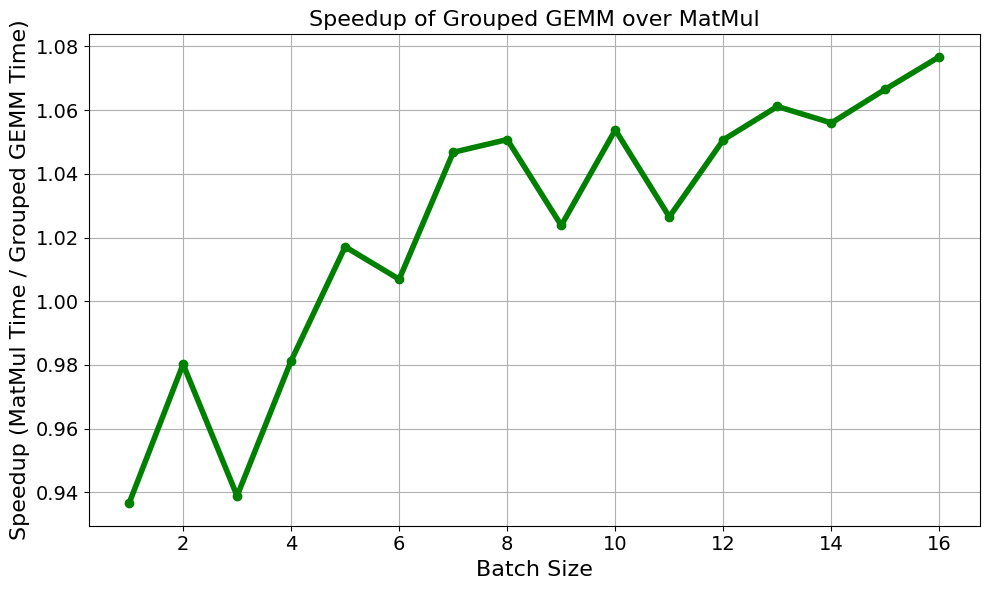

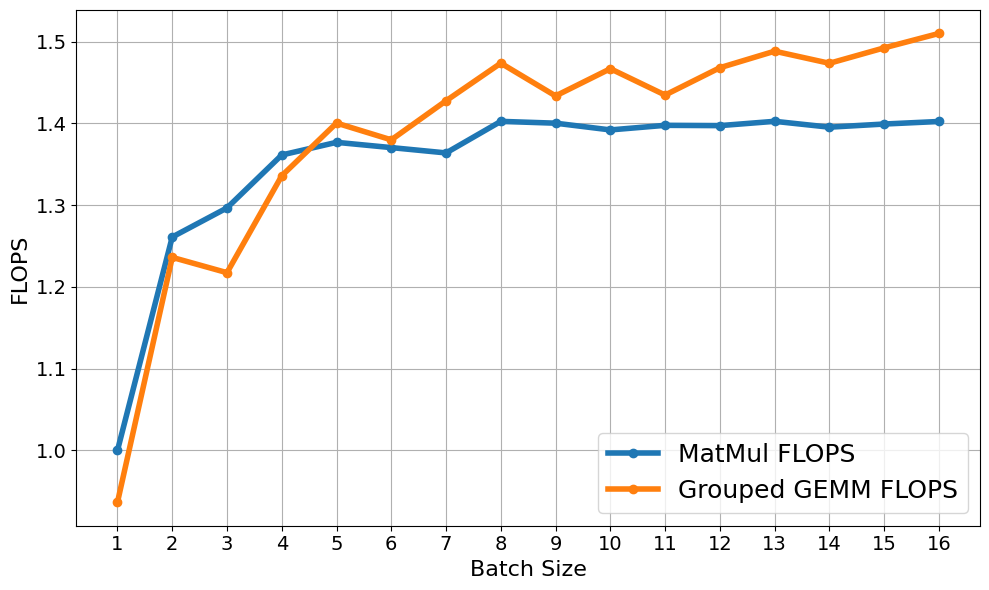

In [18]:
# Plot FLOPS vs Batch Size
import matplotlib.pyplot as plt
import numpy as np

legend_font_size = 18
label_font_size = 16
tick_font_size = 14
line_width = 4  # Increased line width for the graph lines

plt.figure(figsize=(10, 6))
plt.plot(results_df['batch_size'], results_df['matmul_flops'], 'o-', label='MatMul FLOPS', linewidth=line_width)
plt.plot(results_df['batch_size'], results_df['grouped_gemm_flops'], 'o-', label='Grouped GEMM FLOPS', linewidth=line_width)
plt.xlabel('Batch/Group Size', fontsize=label_font_size)
plt.ylabel('FLOPS', fontsize=label_font_size)
# plt.title('Performance Comparison: MatMul vs Grouped GEMM')
plt.legend(fontsize=legend_font_size)
plt.grid(True)
# plt.yscale('log')  # Using log scale for better visualization of large values

# Create more tick points and ensure they're displayed
# tick_values = np.logspace(13.8, 14.33, num=10)  # 10 points between 10^12 and 10^14
# plt.yticks(tick_values, [f'{val:.1e}' for val in tick_values], fontsize=tick_font_size)  # Format as scientific notation
plt.yticks(fontsize=tick_font_size)
plt.gca().yaxis.get_offset_text().set_fontsize(tick_font_size)

# Ensure all x-axis labels are shown
plt.xticks(results_df['batch_size'], results_df['batch_size'], fontsize=tick_font_size)

plt.tight_layout()
plt.savefig(f"{HOME_DIR}/paper_pdfs/gemm_vs_group_scaling_seq1024_hid2048_{DEVICE_NAME}.pdf", bbox_inches='tight')
plt.show()

# Also plot the speedup
plt.figure(figsize=(10, 6))
plt.plot(results_df['batch_size'], results_df['grouped_gemm_flops']/results_df['matmul_flops'], 'o-', color='green', linewidth=line_width)
plt.xlabel('Batch Size', fontsize=label_font_size)
plt.ylabel('Speedup (MatMul Time / Grouped GEMM Time)', fontsize=label_font_size)
plt.title('Speedup of Grouped GEMM over MatMul', fontsize=label_font_size)
plt.grid(True)
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(results_df['batch_size'], results_df['matmul_flops']/results_df['matmul_flops'][0], 'o-', label='MatMul FLOPS', linewidth=line_width)
plt.plot(results_df['batch_size'], results_df['grouped_gemm_flops']/results_df['matmul_flops'][0], 'o-', label='Grouped GEMM FLOPS', linewidth=line_width)
plt.xlabel('Batch Size', fontsize=label_font_size)
plt.ylabel('FLOPS', fontsize=label_font_size)
# plt.title('FLOPS scaling for Grouped GEMM and MatMul compared to MatMul with batch size 1')
plt.legend(fontsize=legend_font_size)
plt.grid(True)
# plt.yscale('log')  # Using log scale for better visualization of large values


# tick_values = np.logspace(13.8, 14.33, num=10)  # 10 points between 10^12 and 10^14
# plt.yticks(tick_values, [f'{val:.1e}' for val in tick_values])  # Format as scientific notation
plt.yticks(fontsize=tick_font_size)
plt.gca().yaxis.get_offset_text().set_fontsize(tick_font_size)

# Ensure all x-axis labels are shown
plt.xticks(results_df['batch_size'], results_df['batch_size'], fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)
plt.tight_layout()
plt.savefig(f"{HOME_DIR}/paper_pdfs/gemm_vs_group_scaling_over_simple_matmul_seq1024_hid2048_{DEVICE_NAME}.pdf", bbox_inches='tight')
plt.show()


In [19]:
# Measure FLOPS for different attention implementations (SDPA, eager, flash_attention2)
import torch
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def measure_attention_implementations_flops(batch_sizes, seq_lengths, head_dims, num_heads):
    results = []
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    for batch_size in batch_sizes:
        for seq_len in seq_lengths:
            for head_dim in head_dims:
                for num_head in num_heads:
                    # Create input tensors
                    q = torch.rand((batch_size, num_head, seq_len, head_dim), device=device, dtype=dtype)
                    k = torch.rand((batch_size, num_head, seq_len, head_dim), device=device, dtype=dtype)
                    v = torch.rand((batch_size, num_head, seq_len, head_dim), device=device, dtype=dtype)
                    
                    # 1. Eager implementation (manual attention)
                    def run_eager_attention():
                        # Q*K^T
                        attn_weights = torch.matmul(q, k.transpose(-1, -2))
                        attn_weights = attn_weights / (head_dim ** 0.5)
                        
                        # Softmax
                        attn_weights = torch.nn.functional.softmax(attn_weights, dim=-1)
                        
                        # Attention * V
                        return torch.matmul(attn_weights, v)
                    
                    # 2. SDPA (Scaled Dot Product Attention)
                    def run_sdpa():
                        with torch.backends.cuda.sdp_kernel(enable_math=False, enable_flash=False, enable_mem_efficient=True):
                            return torch.nn.functional.scaled_dot_product_attention(
                                q, k, v, attn_mask=None, dropout_p=0.0, is_causal=False
                            )
                    
                    # 3. Flash Attention 2 (via SDPA with flash_attention=True)
                    def run_flash_attention():
                        with torch.backends.cuda.sdp_kernel(enable_math=False, enable_flash=True, enable_mem_efficient=False):
                            return torch.nn.functional.scaled_dot_product_attention(
                                q, k, v, attn_mask=None, dropout_p=0.0, is_causal=False, 
                                scale=None
                            )
                    
                    implementations = {
                        "Eager": run_eager_attention,
                        "SDPA": run_sdpa,
                        "Flash Attention 2": run_flash_attention
                    }
                    
                    # Calculate theoretical FLOPS for attention
                    # QK^T: batch_size * num_head * seq_len * seq_len * head_dim
                    # Softmax: negligible compared to matrix multiplications
                    # Attention*V: batch_size * num_head * seq_len * seq_len * head_dim
                    theoretical_flops = 2*(batch_size * num_head * seq_len * seq_len * head_dim) + 2*(batch_size * num_head * seq_len * seq_len * head_dim)
                    # theoretical_flops = 4 * batch_size * num_head * seq_len**2 * head_dim
                    # theoretical_flops = batch_size*( 2 * seq_len**2 * (num_head * head_dim) + 6 * num_head * seq_len**2 )
                    
                    for impl_name, impl_func in implementations.items():
                        try:
                            # Warm-up
                            for _ in range(10):
                                impl_func()
                            
                            torch.cuda.synchronize()
                            
                            # Measure time
                            iterations = 50
                            elapsed_times = []
                            
                            # for _ in range(iterations):
                            #     start_time = time.time()
                            #     impl_func()
                            #     torch.cuda.synchronize()
                            #     end_time = time.time()
                            #     elapsed_times.append(end_time - start_time)
                            
                            start_time = time.time()
                            for _ in range(iterations):
                                q = impl_func()
                            torch.cuda.synchronize()
                            end_time = time.time()
                            elapsed_times.append(end_time - start_time)
                       
                            avg_time = sum(elapsed_times) / iterations
                            flops_per_second = theoretical_flops / avg_time
                            
                            results.append({
                                'implementation': impl_name,
                                'batch_size': batch_size,
                                'seq_len': seq_len,
                                'head_dim': head_dim,
                                'num_heads': num_head,
                                'time': avg_time,
                                'flops': theoretical_flops,
                                'flops_per_second': flops_per_second
                            })
                            
                            print(f"Implementation: {impl_name}, Batch: {batch_size}, Seq: {seq_len}, "
                                  f"Head Dim: {head_dim}, Num Heads: {num_head}")
                            print(f"  Time: {avg_time:.6f}s, FLOPS: {flops_per_second:.2e} FLOPS/s")
                            
                        except Exception as e:
                            print(f"Error with {impl_name}: {e}")
                            # Add to results with error
                            results.append({
                                'implementation': impl_name,
                                'batch_size': batch_size,
                                'seq_len': seq_len,
                                'head_dim': head_dim,
                                'num_heads': num_head,
                                'time': float('nan'),
                                'flops': theoretical_flops,
                                'flops_per_second': float('nan'),
                                'error': str(e)
                            })
    
    return results

# Define parameter ranges
# batch_sizes = [1, 2, 4, 8, 16, 32, 64, 128]
# seq_lengths = [1024] # [512, 1024, 2048]
# head_dims = [128] # [64, 128]
# num_heads = [16] # [8, 16]
# dtype = torch.bfloat16

# batch_sizes = list(range(1, 17)) # + [32, 48, 64] #[8, 16, 32]
# seq_lengths = [1024]
# hidden_sizes = [1024*2]

head_dims = [128]
if len(head_dims) == 1:
    head_dims = head_dims * len(hidden_sizes)
num_heads = [hs//hd for hs, hd in zip(hidden_sizes, head_dims)]

# Run measurements
print("Measuring different attention implementations...")
attention_results = measure_attention_implementations_flops(batch_sizes, seq_lengths, head_dims, num_heads)

# Convert to DataFrame
attention_df = pd.DataFrame(attention_results)

# Display results
display(attention_df)


Measuring different attention implementations...
Implementation: Eager, Batch: 1, Seq: 4096, Head Dim: 128, Num Heads: 16
  Time: 0.003126s, FLOPS: 4.40e+13 FLOPS/s
Implementation: SDPA, Batch: 1, Seq: 4096, Head Dim: 128, Num Heads: 16
  Time: 0.001501s, FLOPS: 9.16e+13 FLOPS/s
Implementation: Flash Attention 2, Batch: 1, Seq: 4096, Head Dim: 128, Num Heads: 16
  Time: 0.000763s, FLOPS: 1.80e+14 FLOPS/s


Implementation: Eager, Batch: 2, Seq: 4096, Head Dim: 128, Num Heads: 16
  Time: 0.006234s, FLOPS: 4.41e+13 FLOPS/s
Implementation: SDPA, Batch: 2, Seq: 4096, Head Dim: 128, Num Heads: 16
  Time: 0.002790s, FLOPS: 9.85e+13 FLOPS/s
Implementation: Flash Attention 2, Batch: 2, Seq: 4096, Head Dim: 128, Num Heads: 16
  Time: 0.001496s, FLOPS: 1.84e+14 FLOPS/s
Implementation: Eager, Batch: 3, Seq: 4096, Head Dim: 128, Num Heads: 16
  Time: 0.009333s, FLOPS: 4.42e+13 FLOPS/s
Implementation: SDPA, Batch: 3, Seq: 4096, Head Dim: 128, Num Heads: 16
  Time: 0.004204s, FLOPS: 9.81e+13 FLOPS/s
Implementation: Flash Attention 2, Batch: 3, Seq: 4096, Head Dim: 128, Num Heads: 16
  Time: 0.002231s, FLOPS: 1.85e+14 FLOPS/s
Implementation: Eager, Batch: 4, Seq: 4096, Head Dim: 128, Num Heads: 16
  Time: 0.012400s, FLOPS: 4.43e+13 FLOPS/s
Implementation: SDPA, Batch: 4, Seq: 4096, Head Dim: 128, Num Heads: 16
  Time: 0.005500s, FLOPS: 1.00e+14 FLOPS/s
Implementation: Flash Attention 2, Batch: 4, Seq: 4

,implementation,batch_size,seq_len,head_dim,num_heads,time,flops,flops_per_second
0,Eager,1,4096,128,16,0.003126,137438953472,4.397228e+13
1,SDPA,1,4096,128,16,0.001501,137438953472,9.157235e+13
2,Flash Attention 2,1,4096,128,16,0.000763,137438953472,1.800821e+14
3,Eager,2,4096,128,16,0.006234,274877906944,4.409357e+13
4,SDPA,2,4096,128,16,0.002790,274877906944,9.853154e+13
5,Flash Attention 2,2,4096,128,16,0.001496,274877906944,1.836851e+14
6,Eager,3,4096,128,16,0.009333,412316860416,4.417895e+13
7,SDPA,3,4096,128,16,0.004204,412316860416,9.807079e+13
8,Flash Attention 2,3,4096,128,16,0.002231,412316860416,1.848338e+14
9,Eager,4,4096,128,16,0.012400,549755813888,4.433415e+13


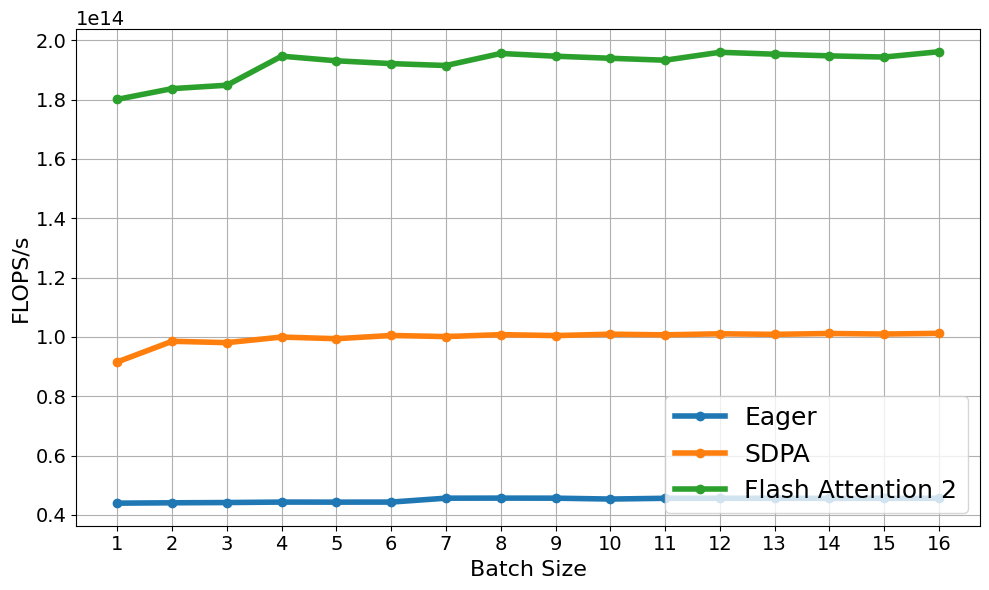

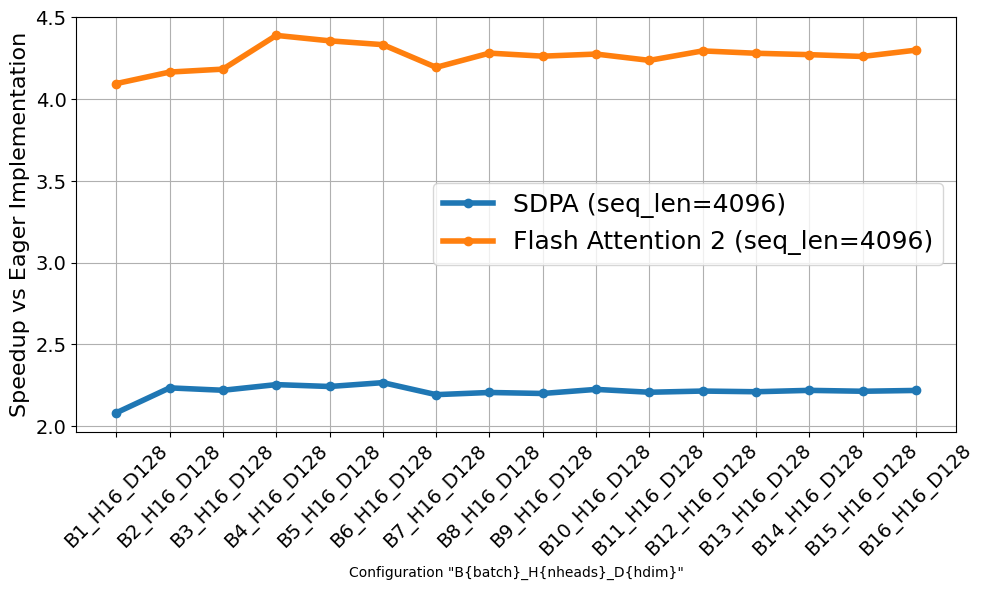

In [20]:
# Plot comparison of FLOPS/s for different implementations
plt.figure(figsize=(10, 6))

# Get unique implementations
implementations = attention_df['implementation'].unique()

# Create a mapping of batch sizes to x-axis positions
batch_sizes_in_data = sorted(attention_df['batch_size'].unique())
batch_size_to_index = {batch: i for i, batch in enumerate(batch_sizes_in_data)}

# Plot data points for each implementation
for impl in implementations:
    impl_data = attention_df[attention_df['implementation'] == impl]
    if not impl_data.empty and not all(np.isnan(impl_data['flops_per_second'])):
        # Sort by batch size for proper line drawing
        impl_data = impl_data.sort_values('batch_size')
        
        # Create x-axis labels
        x_positions = [batch_size_to_index[row['batch_size']] for _, row in impl_data.iterrows()]
        config_labels = [f"B{row['batch_size']}_H{row['num_heads']}_D{row['head_dim']}" 
                         for _, row in impl_data.iterrows()]
        
        # Plot points
        plt.plot(x_positions, impl_data['flops_per_second'], 'o-', label=impl, linewidth=line_width)



plt.xticks(range(len(batch_sizes_in_data)), 
           [b for b in batch_sizes_in_data],
           fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)
plt.gca().yaxis.get_offset_text().set_fontsize(tick_font_size)


plt.xlabel('Batch Size', fontsize=label_font_size)
plt.ylabel('FLOPS/s', fontsize=label_font_size)
# plt.title('Performance Comparison of Different Attention Implementations')
plt.legend(fontsize=legend_font_size, loc='lower right')
plt.grid(True)
# plt.yscale('log')
plt.tight_layout()

# plt.tick_params(axis='y', which='minor', left=False)
plt.savefig(f"{HOME_DIR}/paper_pdfs/attn_scaling_seq1024_hid2048_head128_{DEVICE_NAME}.pdf", bbox_inches='tight')
plt.show()

# Plot speedup relative to eager implementation
plt.figure(figsize=(10, 6))
for seq_len in attention_df['seq_len'].unique():
    seq_data = attention_df[attention_df['seq_len'] == seq_len]
    
    # Group by configuration (excluding implementation)
    config_groups = seq_data.groupby(['batch_size', 'head_dim', 'num_heads'])
    
    speedups = []
    configs = []
    
    for config, group in config_groups:
        eager_time = group[group['implementation'] == 'Eager']['time'].values
        if len(eager_time) == 0 or np.isnan(eager_time[0]):
            continue
            
        for impl in ['SDPA', 'Flash Attention 2']:
            impl_time = group[group['implementation'] == impl]['time'].values
            if len(impl_time) == 0 or np.isnan(impl_time[0]):
                continue
                
            speedup = eager_time[0] / impl_time[0]
            batch, hdim, nheads = config
            speedups.append({
                'implementation': impl,
                'seq_len': seq_len,
                'batch_size': batch,
                'config': f"B{batch}_H{nheads}_D{hdim}",
                'speedup': speedup
            })
    
    if speedups:
        speedup_df = pd.DataFrame(speedups)
        
        # Sort by batch size for proper arrow drawing
        implementations = speedup_df['implementation'].unique()
        batch_sizes_in_speedup = sorted(speedup_df['batch_size'].unique())
        
        for impl in implementations:
            impl_data = speedup_df[speedup_df['implementation'] == impl].sort_values('batch_size')
            
            # Plot points
            plt.plot(impl_data['config'], impl_data['speedup'], 'o-', 
                     label=f"{impl} (seq_len={seq_len})", linewidth=line_width)
            

plt.xlabel('Configuration \"B{batch}_H{nheads}_D{hdim}\"')
plt.ylabel('Speedup vs Eager Implementation', fontsize=label_font_size)
# plt.title('Speedup of SDPA and Flash Attention 2 over Eager Implementation')
plt.legend(fontsize=legend_font_size)
plt.grid(True)
plt.xticks(rotation=45, fontsize=tick_font_size)
# plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)
plt.tight_layout()
plt.show()


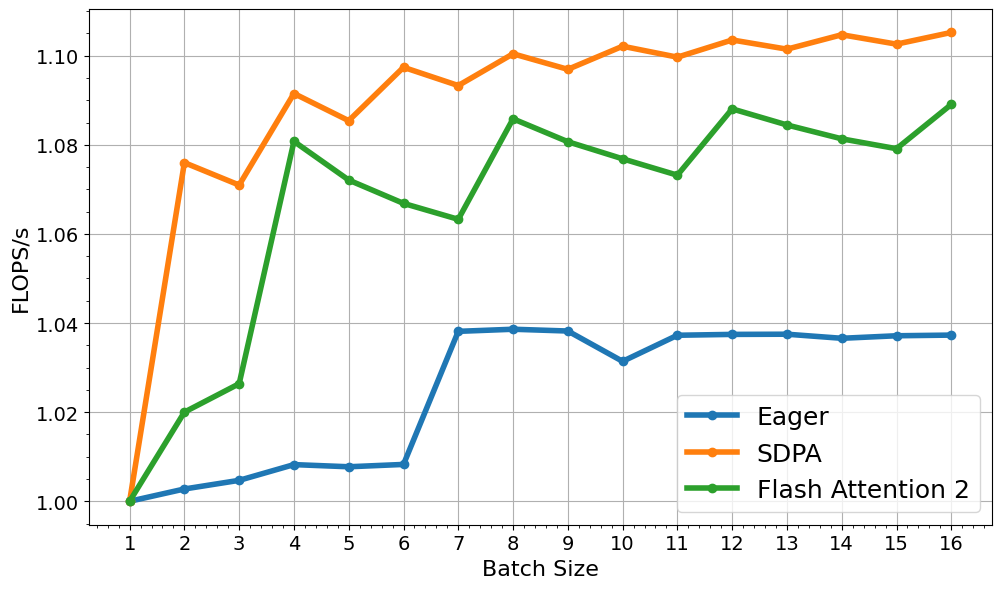

In [22]:
# Plot comparison of FLOPS/s for different implementations
plt.figure(figsize=(10, 6))

# Get unique implementations
implementations = attention_df['implementation'].unique()

# Create a mapping of batch sizes to x-axis positions
batch_sizes_in_data = sorted(attention_df['batch_size'].unique())
batch_size_to_index = {batch: i for i, batch in enumerate(batch_sizes_in_data)}

# Plot data points for each implementation
for impl in implementations:
    impl_data = attention_df[attention_df['implementation'] == impl]
    if not impl_data.empty and not all(np.isnan(impl_data['flops_per_second'])):
        # Sort by batch size for proper line drawing
        impl_data = impl_data.sort_values('batch_size')
        
        # Create x-axis labels
        x_positions = [batch_size_to_index[row['batch_size']] for _, row in impl_data.iterrows()]
        config_labels = [f"B{row['batch_size']}_H{row['num_heads']}_D{row['head_dim']}" 
                         for _, row in impl_data.iterrows()]
        
        # Plot points
        plt.plot(x_positions, impl_data['flops_per_second']/impl_data['flops_per_second'].iloc[0], 'o-', label=impl, linewidth=line_width)


plt.xticks(range(len(batch_sizes_in_data)), 
           [b for b in batch_sizes_in_data],
           fontsize=tick_font_size)

# Make sure all ticks are visible
plt.gca().yaxis.set_tick_params(which='both', labelleft=True)
plt.minorticks_on()
# plt.xlabel('Configuration Index \"B{batch}_H{nheads}_D{hdim}\"')
plt.xlabel('Batch Size', fontsize=label_font_size)
plt.ylabel('FLOPS/s', fontsize=label_font_size)
# plt.title('Performance Comparison of Different Attention Implementations')
plt.legend(fontsize=legend_font_size, loc='lower right')
plt.grid(True)
# plt.yscale('log')
plt.tight_layout()

plt.yticks(fontsize=tick_font_size)

plt.savefig(f"{HOME_DIR}/paper_pdfs/attn_scaling_over_batch1_seq1024_hid2048_head128_{DEVICE_NAME}.pdf", bbox_inches='tight')
plt.show()

In [23]:
impl_data

,implementation,batch_size,seq_len,head_dim,num_heads,time,flops,flops_per_second
2,Flash Attention 2,1,4096,128,16,0.000763,137438953472,1.800821e+14
5,Flash Attention 2,2,4096,128,16,0.001496,274877906944,1.836851e+14
8,Flash Attention 2,3,4096,128,16,0.002231,412316860416,1.848338e+14
11,Flash Attention 2,4,4096,128,16,0.002825,549755813888,1.946266e+14
14,Flash Attention 2,5,4096,128,16,0.003559,687194767360,1.930641e+14
17,Flash Attention 2,6,4096,128,16,0.004292,824633720832,1.921209e+14
20,Flash Attention 2,7,4096,128,16,0.005024,962072674304,1.914769e+14
23,Flash Attention 2,8,4096,128,16,0.005623,1099511627776,1.955390e+14
26,Flash Attention 2,9,4096,128,16,0.006356,1236950581248,1.946134e+14
29,Flash Attention 2,10,4096,128,16,0.007087,1374389534720,1.939227e+14


In [24]:
attention_df

,implementation,batch_size,seq_len,head_dim,num_heads,time,flops,flops_per_second
0,Eager,1,4096,128,16,0.003126,137438953472,4.397228e+13
1,SDPA,1,4096,128,16,0.001501,137438953472,9.157235e+13
2,Flash Attention 2,1,4096,128,16,0.000763,137438953472,1.800821e+14
3,Eager,2,4096,128,16,0.006234,274877906944,4.409357e+13
4,SDPA,2,4096,128,16,0.002790,274877906944,9.853154e+13
5,Flash Attention 2,2,4096,128,16,0.001496,274877906944,1.836851e+14
6,Eager,3,4096,128,16,0.009333,412316860416,4.417895e+13
7,SDPA,3,4096,128,16,0.004204,412316860416,9.807079e+13
8,Flash Attention 2,3,4096,128,16,0.002231,412316860416,1.848338e+14
9,Eager,4,4096,128,16,0.012400,549755813888,4.433415e+13
